
*   Micah Simmerman
*   CSPB 3022 
*   Semester Project
*   December 5, 2020 
*   Contributers= none 


For this project, I decided to try my hand at a more advanced regression technique and generate a random forest regression model to predict house prices based on 79 explanatory variables. The training and test data came from the "House Prices: Advanced Regression Techniques" Kaggle competition at https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data. 

Random forest regression is part of the sklearn data science tool ensemble. Using the random forest regression tool kit is surprisingly simple once the input data has been properly cleaned and processed. Random forest regression is a tree-generating machine learning technique that can be used for both regression and classification problems. Random forest algorithms are purported to avoid overfitting through the use of statistical averaging, and typically result in very short learning times. The random forest regression tool gets its' name from the mulitple decision trees that it generates (one might call it a forest of trees!). After the model has produced a series of decision tress based on a bootstrap-like sampling of the data, test input is delivered to the model and the algorithm determines the most likely outcome based on the averaged decision of each tree that was generated during the fit. 

Random forest regression and/or classification is commonly regarded as an accurate technique for efficiently processing large data sets, and is also considered quite robust in handling data sets with a lot of missing information. The random forest model searches for "high-gain" predictors at the initial stages of the fitting process, searching for predictors that result in the greatest improvement in predicting classification or regression outcomes. Since the house price data is essentially a list of house characteristics associated with a price tag, this decision tree model seemed like a natural first choice. 


In [4]:
# Import python processing packages that we may need (I did not end up using every one of them).
import numpy as np
import pandas as pd
import pandas.util.testing as tm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sp
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn import datasets
from sklearn.ensemble import RandomForestRegressor
import patsy
import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.ensemble import RandomForestRegressor

In [5]:
# Read in the training and test data and store them under variables.
training_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
house_id = test_data["Id"]
house_id.to_csv('house_id.csv', index=False)

In [6]:
# Take a look at the training data.
training_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
# Observe some of the training set statistics.
training_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


Text(0, 0.5, 'Count')

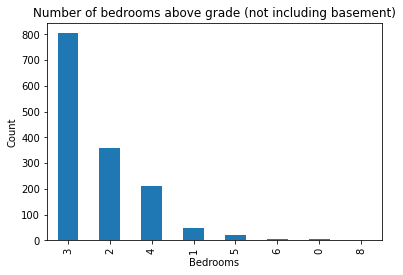

In [8]:
# Visualize the distribution of bedrooms (this gives us an idea of what size of houses we are dealing with).
training_data["BedroomAbvGr"].value_counts().plot(kind='bar')
plt.title('Number of bedrooms above grade (not including basement)')
plt.xlabel('Bedrooms')
plt.ylabel('Count')

RL	Residential Low Density
RM	Residential Medium Density
FV	Floating Village Residential
C	Commercial
RH	Residential High Density


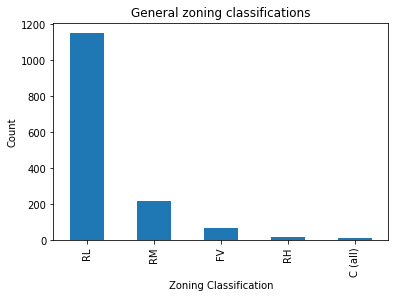

In [9]:
# Observe the zoning differences between houses, ie what kind of houses these are, and approximately what type of area they are located in.
training_data["MSZoning"].value_counts().plot(kind='bar')
plt.title('General zoning classifications')
plt.xlabel('Zoning Classification')
plt.ylabel('Count')
# Print a variable key
print('RL	Residential Low Density')
print('RM	Residential Medium Density')
print('FV	Floating Village Residential')
print('C	Commercial')
print('RH	Residential High Density')

20	1-STORY 1946 & NEWER ALL STYLES 
 30	1-STORY 1945 & OLDER 
 40	1-STORY W/FINISHED ATTIC ALL AGES 
 45	1-1/2 STORY - UNFINISHED ALL AGES 
 50	1-1/2 STORY FINISHED ALL AGES 
 60	2-STORY 1946 & NEWER 
 70	2-STORY 1945 & OLDER 
 75	2-1/2 STORY ALL AGES 
 80	SPLIT OR MULTI-LEVEL 
 85	SPLIT FOYER 
 90	DUPLEX - ALL STYLES AND AGES 
 120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER 
 150	1-1/2 STORY PUD - ALL AGES 
 160	2-STORY PUD - 1946 & NEWER 
 180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER 
 190	2 FAMILY CONVERSION - ALL STYLES AND AGES


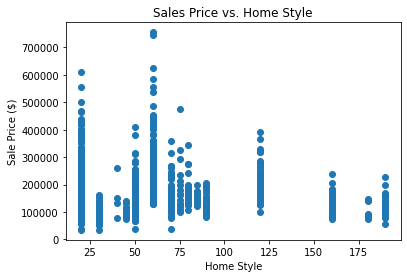

In [10]:
# Plot housing prices as a function of house type (categorical)
plt.scatter(training_data.MSSubClass,training_data.SalePrice)
plt.title('Sales Price vs. Home Style')
plt.xlabel('Home Style')
plt.ylabel('Sale Price ($)')
# Print a variable key
print('20	1-STORY 1946 & NEWER ALL STYLES \n',
        '30	1-STORY 1945 & OLDER \n',
        '40	1-STORY W/FINISHED ATTIC ALL AGES \n',
        '45	1-1/2 STORY - UNFINISHED ALL AGES \n',
        '50	1-1/2 STORY FINISHED ALL AGES \n',
        '60	2-STORY 1946 & NEWER \n',
        '70	2-STORY 1945 & OLDER \n',
        '75	2-1/2 STORY ALL AGES \n',
        '80	SPLIT OR MULTI-LEVEL \n',
        '85	SPLIT FOYER \n',
        '90	DUPLEX - ALL STYLES AND AGES \n',
       '120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER \n',
       '150	1-1/2 STORY PUD - ALL AGES \n',
       '160	2-STORY PUD - 1946 & NEWER \n',
       '180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER \n',
       '190	2 FAMILY CONVERSION - ALL STYLES AND AGES')

In [11]:
# Create x_train and y_train training sets
x_train = training_data.drop(['SalePrice'],axis=1)
# Home ID is not an indicator of sale value
x_train = training_data.drop(['Id'],axis=1)
# Separate the training data SalePrice column to use as the dependent variable.
y_train = training_data['SalePrice']
# Create the x_test test set
x_test = test_data

In [12]:
# Look at the test set data
x_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


The test data has no sale price column. This means that we cannot create a confusion matrix to test the accuracy of the model.

In [13]:
# Let's have a look at the data types included in this set to figure out what type of data processing may be needed.
x_train.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 80, dtype: object

In [14]:
#x_test.dtypes

In [15]:
# Process categorical variables into dummy variables to feed the regression model.
encode = preprocessing.LabelEncoder()
for feat in x_train:
    # First, transform all of the object features of the set into a string
    x_train[feat] = encode.fit_transform(x_train[feat].astype(str))
# Then apply the label encoder to give each categorical attribute a corresponding number that the regressor can work with.
x_train = x_train.apply(LabelEncoder().fit_transform)
# Check that the data types were transformed
x_train.dtypes

# Generate a random forest regression model
Random_forest_reg_model = RandomForestRegressor()
# Train the model on the training sets.
Random_forest_reg_model.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [16]:
# Process categorical values in x_test to feed to the random forest regression model. 
for feat in x_test:
    # First, transform all of the object features of the set into a string
    x_test[feat] = encode.fit_transform(x_test[feat].astype(str))
# Then apply the label encoder to give each categorical attribute a corresponding number that the regressor can work with.
x_test = x_test.apply(LabelEncoder().fit_transform)

# Predict the price of each home given in the x_test test set
price_predict = Random_forest_reg_model.predict(x_test)
# Turn the result back into a pandas dataframe object
price_predict = pd.DataFrame(price_predict)
# Label the column
price_predict.columns = ['Estimated Sale Price ($)']

# Attach the house identifier to the regression results
price_predict_1 = price_predict.join(house_id)
price_predict_2 = price_predict_1[['Id', 'Estimated Sale Price ($)']]

# Write results to a csv file
price_predict_2.to_csv('result.csv', index=False)

# Show the result.
price_predict_2.head()

,Id,Estimated Sale Price ($)
0,0,109187.12
1,1,102598.68
2,2,109234.60
3,3,102635.16
4,4,109096.12


In [17]:
# Determine which features are the most predictive of sale value. 
feature_weights = pd.DataFrame(Random_forest_reg_model.feature_importances_, index = x_test.columns, columns=['importance']).sort_values('importance', ascending=False)
print(feature_weights)

                 importance
SaleCondition  4.332286e-01
HouseStyle     2.250920e-01
GarageFinish   2.239742e-01
MasVnrArea     3.983819e-02
BsmtHalfBath   1.663218e-02
...                     ...
TotalBsmtSF    7.722426e-07
MiscFeature    2.207408e-07
LotArea        1.510421e-07
EnclosedPorch  3.238367e-08
LandContour    6.004598e-10

[80 rows x 1 columns]


The top three factors of importance appear to be SaleCondition, HouseStyle, and GarageFinish. Random forest regression is a fairly fast, it appears to make quick work of large data sets. Top predictors appear to change occasionally from run to run.

After submitting this entry on Kaggle, I recieved an initial score of 0.60940, putting me in 4,817th place (not great! haha). After playing around with a linear regression model and becoming frustrated with the results, I decided to try and improve upon my existing model by incorporating a cross-validation technique called "grid hyperparameter search optimization", following a procedure outlined here: https://medium.com/@ODSC/optimizing-hyperparameters-for-random-forest-algorithms-in-scikit-learn-d60b7aa07ead.

In [18]:
# Give the model some grid parameters to optimize with
n_estimators=[500,800,1500,2500,5000]  #number of trees in the forest
max_features=['auto','sqrt','log2']  #features to be tested, autoselected (default), the square root of the number of samples (n), and log2(n)
max_depth=[10,20,30,40,50]  # Specified maximum tree depth
#max_depth.append(None)  # Enables unlimited tree depth, (I found this line contributed to a lot of runaway behavior in the model, so I decided to remove it)
min_samples_split=[2,5,10,15,20]  #minimum number of samples required to split a node
min_samples_leaf=[1,2,5,10,15]

# Create a library framework that the RandomForestRegressor can use to optimize the model
grid_paramaters = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf}

#Import additional libraries
from sklearn.model_selection import RandomizedSearchCV
RFR = RandomForestRegressor(random_state=1)
RFR_random = RandomizedSearchCV(estimator = RFR, param_distributions = grid_paramaters, n_iter=300, cv=5, verbose = 2, random_state=42, n_jobs=-1)

# Fit the model using optimized hyperparameters
RFR_random.fit(x_train,y_train)
print(RFR_random.best_params_)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 48.2min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 84.7min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 135.5min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 216.9min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 223.3min finished


{'n_estimators': 5000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 30}


In [30]:
# Create another prediction and send it to a csv for submission. 
RFR_predict = RFR_random.predict(x_test)
RFR_predict = pd.DataFrame(RFR_predict)
RFR_predict.columns = ['SalePrice']
RFR_predict.head()
RFR_predict.to_csv('Tuned_result.csv', index=False)


Conclusion:

Although the sklearn random forest algorithm is an exciting and somewhat new concept, it may not be the best tool for the job. The Sklearn random forest hyperparameter tuning process is a very time and memory intensive process (taking approximately 223.3 minutes to execute). Tuning the parameters of the random forest regressor model resulted in only a modest improvement over the previous submission, tipping my score up to .60522 from 0.60940 (a lower value means higher predictive accuracy), this was a disappointing improvement in performance for the time spent retraining the model. Given the large number of factors and data points in this set, it is difficult to know what model(s) would achieve the highest level of performance. Both forward and backward model selection presented significant challenges in predicting a data set of this size after my first submission. Not the least of which that ols would not operate if given 79 parameters, making backward selection essentially impossible and forward selection exceedingly difficult to organize.

If I had to attempt this competition again (which I may) I would develop an algorithm to automate a forward selection regression model. This automation seems necessary given the large number of factors and points in the data set, as well as the confusion that inevitably results from keeping the forward-selection process organized. 

I found this competition to be particularly challenging since I could not assess the test fit of my models prior to submission (no answer to the test set is given). Not having this information made it impossible to assess if my model was overfitted on the training data. The process of designing a predictive model could be improved by incorporating additional data sets to train and test on. 

I learned a lot about random forest algorithms during this project. It appears that this tool is becoming very popular in machine learning concepts such as motion sensing and object classification. This particular problem set may not have been the best match for RFR, however. 

Helpful Websites:

*   https://www.youtube.com/watch?v=eM4uJ6XGnSM
*   https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
*   https://www.kaggle.com/learn-forum/61148
*   https://heartbeat.fritz.ai/random-forest-regression-in-python-using-scikit-learn-9e9b147e2153
*   https://www.datacamp.com/community/tutorials/random-forests-classifier-python?utm_source=adwords_ppc&utm_campaignid=1565261270&utm_adgroupid=67750485268&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=295208661514&utm_targetid=aud-299261629574:dsa-429603003980&utm_loc_interest_ms=&utm_loc_physical_ms=9028792&gclid=CjwKCAiA_Kz-BRAJEiwAhJNY79OVMv5NfuggDGLl9TuXQQ3KSFqNy0gjG96LZj5ORcU7Dk-5aVaRExoC6msQAvD_BwE#algorithm

















Leaderboard URLs and Kaggle info:
Kaggle UN:
Micah JASI9001

1st Entry:
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/leaderboard

2nd Entry:
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/leaderboard

